In [1]:
%matplotlib inline
from typing import List, Callable
import pandas as pd
from sklearn.cluster import (KMeans, DBSCAN, Birch)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score, silhouette_samples
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import (Arc, Ellipse)
from pandas.plotting import parallel_coordinates
from tqdm.notebook import tqdm

## Огляд вихідних даних

In [2]:
datafile= 'data/players_dataset.csv'

In [3]:
initial_data = pd.read_csv(datafile, sep=';')

In [4]:
initial_data.head()

overall_rating  potential   value_euro  wage_euro  \
0              94         94  110500000.0   565000.0   
1              88         89   69500000.0   205000.0   
2              88         91   73000000.0   255000.0   
3              88         88   62000000.0   165000.0   
4              63         77     800000.0     3000.0   

   international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5)  \
0                              5               4                 4   
1                              3               5                 4   
2                              4               4                 5   
3                              3               4                 4   
4                              1               2                 3   

   release_clause_euro  crossing  finishing  ...  penalties  composure  \
0          226500000.0        86         95  ...         75         96   
1          133800000.0        88         81  ...         67         88   
2          144200000.0        80         75  ...         82         87   
3          105400000.0        86         77  ...         61         83   
4            2100000.0        53         50  ...         60         61   

   marking  standing_tackle  sliding_tackle  GK_diving  GK_handling  \
0       33               28              26          6           11   
1       59               57              22          9           14   
2       63               67              67          5            6   
3       51               24              22          8            4   
4       41               40              47         10           13   

   GK_kicking  GK_positioning  GK_reflexes  
0          15              14            8  
1           7               7            6  
2           2               4            3  
3          14               9           10  
4           8              11           14  

[5 rows x 42 columns]

In [5]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9012 entries, 0 to 9011
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   overall_rating                 9012 non-null   int64  
 1   potential                      9012 non-null   int64  
 2   value_euro                     8861 non-null   float64
 3   wage_euro                      8864 non-null   float64
 4   international_reputation(1-5)  9012 non-null   int64  
 5   weak_foot(1-5)                 9012 non-null   int64  
 6   skill_moves(1-5)               9012 non-null   int64  
 7   release_clause_euro            7963 non-null   float64
 8   crossing                       9012 non-null   int64  
 9   finishing                      9012 non-null   int64  
 10  heading_accuracy               9012 non-null   int64  
 11  short_passing                  9012 non-null   int64  
 12  volleys                        9012 non-null   i

In [6]:
missing_data = initial_data.shape[0] - initial_data.count()
print(missing_data[missing_data != 0])

value_euro              151
wage_euro               148
release_clause_euro    1049
dtype: int64


In [7]:
initial_data.describe(include = 'all')

overall_rating    potential    value_euro      wage_euro  \
count     9012.000000  9012.000000  8.861000e+03    8864.000000   
mean        69.770750    73.046383  3.445543e+06   13489.959386   
std          4.849281     5.608650  6.490245e+06   25741.310005   
min         59.000000    63.000000  2.000000e+04    1000.000000   
25%         66.000000    69.000000  6.750000e+05    3000.000000   
50%         69.000000    72.000000  1.200000e+06    6000.000000   
75%         73.000000    77.000000  3.600000e+06   14000.000000   
max         94.000000    94.000000  1.105000e+08  565000.000000   

       international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5)  \
count                    9012.000000     9012.000000       9012.000000   
mean                        1.160009        3.018309          2.530737   
std                         0.462231        0.676178          0.779871   
min                         1.000000        1.000000          1.000000   
25%                         1.000000        3.000000          2.000000   
50%                         1.000000        3.000000          3.000000   
75%                         1.000000        3.000000          3.000000   
max                         5.000000        5.000000          5.000000   

       release_clause_euro     crossing    finishing  ...    penalties  \
count         7.963000e+03  9012.000000  9012.000000  ...  9012.000000   
mean          6.528110e+06    53.764425    48.761318  ...    51.092876   
std           1.303581e+07    18.145795    19.470067  ...    15.537202   
min           3.800000e+04     5.000000     2.000000  ...     9.000000   
25%           1.100000e+06    44.000000    33.000000  ...    41.000000   
50%           2.000000e+06    59.000000    53.000000  ...    53.000000   
75%           6.400000e+06    67.000000    65.000000  ...    63.000000   
max           2.265000e+08    93.000000    95.000000  ...    91.000000   

         composure      marking  standing_tackle  sliding_tackle   GK_diving  \
count  9012.000000  9012.000000      9012.000000     9012.000000  9012.00000   
mean     63.087106    50.581225        50.958833       48.581225    16.27308   
std       9.691299    20.072960        21.906186       21.710481    17.84360   
min      12.000000     3.000000         6.000000        4.000000     1.00000   
25%      58.000000    32.000000        30.000000       27.000000     8.00000   
50%      64.000000    58.000000        61.000000       58.000000    11.00000   
75%      69.000000    67.000000        69.000000       67.000000    14.00000   
max      96.000000    94.000000        93.000000       90.000000    90.00000   

       GK_handling   GK_kicking  GK_positioning  GK_reflexes  
count  9012.000000  9012.000000     9012.000000  9012.000000  
mean     16.059587    15.902241       16.148580    16.391811  
std      17.027461    16.564563       17.390257    18.199737  
min       1.000000     1.000000        1.000000     1.000000  
25%       8.000000     8.000000        8.000000     8.000000  
50%      11.000000    11.000000       11.000000    11.000000  
75%      14.000000    14.000000       14.000000    14.000000  
max      92.000000    92.000000       90.000000    94.000000  

[8 rows x 42 columns]

In [8]:
explore = initial_data.describe(percentiles=[], include='all', datetime_is_numeric=True).T
explore['null'] = len(initial_data)-explore['count']

In [9]:
explore = explore[['null','max','min', 'count']]
explore

null          max      min   count
overall_rating                    0.0         94.0     59.0  9012.0
potential                         0.0         94.0     63.0  9012.0
value_euro                      151.0  110500000.0  20000.0  8861.0
wage_euro                       148.0     565000.0   1000.0  8864.0
international_reputation(1-5)     0.0          5.0      1.0  9012.0
weak_foot(1-5)                    0.0          5.0      1.0  9012.0
skill_moves(1-5)                  0.0          5.0      1.0  9012.0
release_clause_euro            1049.0  226500000.0  38000.0  7963.0
crossing                          0.0         93.0      5.0  9012.0
finishing                         0.0         95.0      2.0  9012.0
heading_accuracy                  0.0         94.0      5.0  9012.0
short_passing                     0.0         93.0      7.0  9012.0
volleys                           0.0         90.0      4.0  9012.0
dribbling                         0.0         97.0      4.0  9012.0
curve                             0.0         94.0      6.0  9012.0
freekick_accuracy                 0.0         94.0      7.0  9012.0
long_passing                      0.0         93.0      9.0  9012.0
ball_control                      0.0         96.0      8.0  9012.0
acceleration                      0.0         97.0     12.0  9012.0
sprint_speed                      0.0         96.0     13.0  9012.0
agility                           0.0         96.0     18.0  9012.0
reactions                         0.0         96.0     32.0  9012.0
balance                           0.0         96.0     16.0  9012.0
shot_power                        0.0         95.0      3.0  9012.0
jumping                           0.0         95.0     23.0  9012.0
stamina                           0.0         97.0     13.0  9012.0
strength                          0.0         97.0     20.0  9012.0
long_shots                        0.0         94.0      4.0  9012.0
aggression                        0.0         94.0     11.0  9012.0
interceptions                     0.0         92.0      6.0  9012.0
positioning                       0.0         95.0      2.0  9012.0
vision                            0.0         94.0     10.0  9012.0
penalties                         0.0         91.0      9.0  9012.0
composure                         0.0         96.0     12.0  9012.0
marking                           0.0         94.0      3.0  9012.0
standing_tackle                   0.0         93.0      6.0  9012.0
sliding_tackle                    0.0         90.0      4.0  9012.0
GK_diving                         0.0         90.0      1.0  9012.0
GK_handling                       0.0         92.0      1.0  9012.0
GK_kicking                        0.0         92.0      1.0  9012.0
GK_positioning                    0.0         90.0      1.0  9012.0
GK_reflexes                       0.0         94.0      1.0  9012.0

## Очищення даних

In [10]:
cleanedfile = 'data/data_cleaned.csv'

Прибираємо записи з пустими полями

In [11]:
initial_data = initial_data[initial_data['value_euro'].notnull()&initial_data['wage_euro'].notnull()&initial_data['release_clause_euro'].notnull()]

In [12]:
# initial_data.hist(figsize=(30, 50))

Зберігаємо проміжні, очищені данні у csv файл

In [13]:
initial_data.to_csv(cleanedfile, index=False)

## Маштабування ознак

In [14]:
inputfile = 'data/data_cleaned.csv'
outputfile_minmax = 'data/minmax_data.csv'

In [15]:
initial_data_raw = pd.read_csv(inputfile,header=0) #first row used as header
initial_data_raw.head()

overall_rating  potential   value_euro  wage_euro  \
0              94         94  110500000.0   565000.0   
1              88         89   69500000.0   205000.0   
2              88         91   73000000.0   255000.0   
3              88         88   62000000.0   165000.0   
4              63         77     800000.0     3000.0   

   international_reputation(1-5)  weak_foot(1-5)  skill_moves(1-5)  \
0                              5               4                 4   
1                              3               5                 4   
2                              4               4                 5   
3                              3               4                 4   
4                              1               2                 3   

   release_clause_euro  crossing  finishing  ...  penalties  composure  \
0          226500000.0        86         95  ...         75         96   
1          133800000.0        88         81  ...         67         88   
2          144200000.0        80         75  ...         82         87   
3          105400000.0        86         77  ...         61         83   
4            2100000.0        53         50  ...         60         61   

   marking  standing_tackle  sliding_tackle  GK_diving  GK_handling  \
0       33               28              26          6           11   
1       59               57              22          9           14   
2       63               67              67          5            6   
3       51               24              22          8            4   
4       41               40              47         10           13   

   GK_kicking  GK_positioning  GK_reflexes  
0          15              14            8  
1           7               7            6  
2           2               4            3  
3          14               9           10  
4           8              11           14  

[5 rows x 42 columns]

Для нормалізації візьмено


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [16]:
scaler_minmax = MinMaxScaler()

In [17]:
data_minmax = pd.DataFrame(scaler_minmax.fit_transform(initial_data_raw.values), columns=[f'MinMax_{col}' for col in initial_data_raw.columns])

In [18]:
data_minmax.head()

MinMax_overall_rating  MinMax_potential  MinMax_value_euro  \
0               1.000000          1.000000           1.000000   
1               0.828571          0.838710           0.628892   
2               0.828571          0.903226           0.660572   
3               0.828571          0.806452           0.561007   
4               0.114286          0.451613           0.007060   

   MinMax_wage_euro  MinMax_international_reputation(1-5)  \
0          1.000000                                  1.00   
1          0.361702                                  0.50   
2          0.450355                                  0.75   
3          0.290780                                  0.50   
4          0.003546                                  0.00   

   MinMax_weak_foot(1-5)  MinMax_skill_moves(1-5)  MinMax_release_clause_euro  \
0                   0.75                     0.75                    1.000000   
1                   1.00                     0.75                    0.590660   
2                   0.75                     1.00                    0.636584   
3                   0.75                     0.75                    0.465252   
4                   0.25                     0.50                    0.009105   

   MinMax_crossing  MinMax_finishing  ...  MinMax_penalties  MinMax_composure  \
0         0.920455          1.000000  ...          0.804878          1.000000   
1         0.943182          0.849462  ...          0.707317          0.904762   
2         0.852273          0.784946  ...          0.890244          0.892857   
3         0.920455          0.806452  ...          0.634146          0.845238   
4         0.545455          0.516129  ...          0.621951          0.583333   

   MinMax_marking  MinMax_standing_tackle  MinMax_sliding_tackle  \
0        0.329670                0.252874               0.255814   
1        0.615385                0.586207               0.209302   
2        0.659341                0.701149               0.732558   
3        0.527473                0.206897               0.209302   
4        0.417582                0.390805               0.500000   

   MinMax_GK_diving  MinMax_GK_handling  MinMax_GK_kicking  \
0          0.056180            0.109890           0.153846   
1          0.089888            0.142857           0.065934   
2          0.044944            0.054945           0.010989   
3          0.078652            0.032967           0.142857   
4          0.101124            0.131868           0.076923   

   MinMax_GK_positioning  MinMax_GK_reflexes  
0               0.146067            0.075269  
1               0.067416            0.053763  
2               0.033708            0.021505  
3               0.089888            0.096774  
4               0.112360            0.139785  

[5 rows x 42 columns]

In [19]:
data_minmax.to_csv(outputfile_minmax,index=False)

 ## Підбір найкращого epsilon та min_samples

Для підбору найкращого epsilon візьмемо метрику

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [20]:
inputfile = 'data/minmax_data.csv'

In [21]:
data_minmax = pd.read_csv(inputfile,header=0)
data_minmax.head()

MinMax_overall_rating  MinMax_potential  MinMax_value_euro  \
0               1.000000          1.000000           1.000000   
1               0.828571          0.838710           0.628892   
2               0.828571          0.903226           0.660572   
3               0.828571          0.806452           0.561007   
4               0.114286          0.451613           0.007060   

   MinMax_wage_euro  MinMax_international_reputation(1-5)  \
0          1.000000                                  1.00   
1          0.361702                                  0.50   
2          0.450355                                  0.75   
3          0.290780                                  0.50   
4          0.003546                                  0.00   

   MinMax_weak_foot(1-5)  MinMax_skill_moves(1-5)  MinMax_release_clause_euro  \
0                   0.75                     0.75                    1.000000   
1                   1.00                     0.75                    0.590660   
2                   0.75                     1.00                    0.636584   
3                   0.75                     0.75                    0.465252   
4                   0.25                     0.50                    0.009105   

   MinMax_crossing  MinMax_finishing  ...  MinMax_penalties  MinMax_composure  \
0         0.920455          1.000000  ...          0.804878          1.000000   
1         0.943182          0.849462  ...          0.707317          0.904762   
2         0.852273          0.784946  ...          0.890244          0.892857   
3         0.920455          0.806452  ...          0.634146          0.845238   
4         0.545455          0.516129  ...          0.621951          0.583333   

   MinMax_marking  MinMax_standing_tackle  MinMax_sliding_tackle  \
0        0.329670                0.252874               0.255814   
1        0.615385                0.586207               0.209302   
2        0.659341                0.701149               0.732558   
3        0.527473                0.206897               0.209302   
4        0.417582                0.390805               0.500000   

   MinMax_GK_diving  MinMax_GK_handling  MinMax_GK_kicking  \
0          0.056180            0.109890           0.153846   
1          0.089888            0.142857           0.065934   
2          0.044944            0.054945           0.010989   
3          0.078652            0.032967           0.142857   
4          0.101124            0.131868           0.076923   

   MinMax_GK_positioning  MinMax_GK_reflexes  
0               0.146067            0.075269  
1               0.067416            0.053763  
2               0.033708            0.021505  
3               0.089888            0.096774  
4               0.112360            0.139785  

[5 rows x 42 columns]

In [22]:
data_minmax_droped = data_minmax.drop(columns=[f'MinMax_{name}' for name in (
    'value_euro',
    'wage_euro',
    'international_reputation(1-5)',
    'weak_foot(1-5)',
    'skill_moves(1-5)',
    'skill_moves(1-5)',
    'release_clause_euro')
    ])

## DBSCAN



https://towardsdatascience.com/dbscan-clustering-algorithm-how-to-build-powerful-density-based-models-21d9961c4cec

https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c

In [23]:
def calculate_silhouette_scores(x: np.ndarray, eps_range, min_samples_range):
    # Create empty lists
    scores=[] # this is to store Silhouette scores
    comb=[] # this is to store combinations of epsilon / min_samples
    clasters=[]
    eps_idx = []
    min_samples_idx = []

    for i, epsilon in tqdm(list(enumerate(eps_range))):
        for j, min_samples in enumerate(min_samples_range):
            # Set the model and its parameters
            model = DBSCAN(eps=epsilon, min_samples=min_samples)
            # Fit the model 
            clm = model.fit(x)
            ulabels = np.unique(clm.labels_)
            # Calculate Silhoutte Score and append to a list
            if ulabels.shape[0] > 1:
                scores.append(silhouette_score(x, clm.labels_, metric='euclidean'))
            else:
                scores.append(-1)
            # print(f'{k} {j} {clm.labels_.shape} {np.unique(clm.labels_)}')
            comb.append(f'{epsilon:.3}|{min_samples}') # axis values for the graph
            clasters.append(ulabels.shape[0])
            eps_idx.append(i)
            min_samples_idx.append(j)
    return scores, comb, clasters, eps_idx, min_samples_idx

In [24]:
def process_nn(X: np.ndarray):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances, indices, neigh

In [25]:
def plot_silhouette_scores(scores: List[float], comb: List[str], figsize=(16, 8)):
    plt.figure(figsize=figsize, dpi=100)
    plt.plot(comb, scores, 'bo-')
    plt.xlabel('epsilon | min_samples')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score на основі різних параметрів epsilon і min_samples')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

In [26]:
epsilons = np.linspace(.1, 1.0, num=100, dtype=np.float64)
min_points = [10, 43]

In [27]:
np.float64(98/100)

0.98

In [28]:
epsilons

array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.38181818, 0.39090909, 0.4       , 0.40909091,
       0.41818182, 0.42727273, 0.43636364, 0.44545455, 0.45454545,
       0.46363636, 0.47272727, 0.48181818, 0.49090909, 0.5       ,
       0.50909091, 0.51818182, 0.52727273, 0.53636364, 0.54545455,
       0.55454545, 0.56363636, 0.57272727, 0.58181818, 0.59090909,
       0.6       , 0.60909091, 0.61818182, 0.62727273, 0.63636364,
       0.64545455, 0.65454545, 0.66363636, 0.67272727, 0.68181818,
       0.69090909, 0.7       , 0.70909091, 0.71818182, 0.72727273,
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272

In [29]:
scores, comb, cls_count, eps_idx, min_samples_idx = calculate_silhouette_scores(data_minmax.values, epsilons, min_points)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
# scores1, comb1, cls_count1 = calculate_silhouette_scores(data_minmax.values, [50, 98, 500], [10, 1000, 100])

In [31]:
idx = scores.index(max(scores))
best_score=scores[idx]
best_comb=comb[idx]
best_score, best_comb, epsilons[eps_idx[idx]], min_points[min_samples_idx[idx]]

(0.5662968831426859, '0.982|10', 0.9818181818181817, 10)

In [32]:
dbscan_model = DBSCAN(eps=epsilons[eps_idx[idx]], min_samples=min_points[min_samples_idx[idx]])
dbscan_model.fit(data_minmax.values)
dbscan_model.labels_

array([0, 0, 0, ..., 1, 0, 0])

In [33]:
pd.Series(dbscan_model.labels_).value_counts() # cluster count

0    7182
1     781
dtype: int64

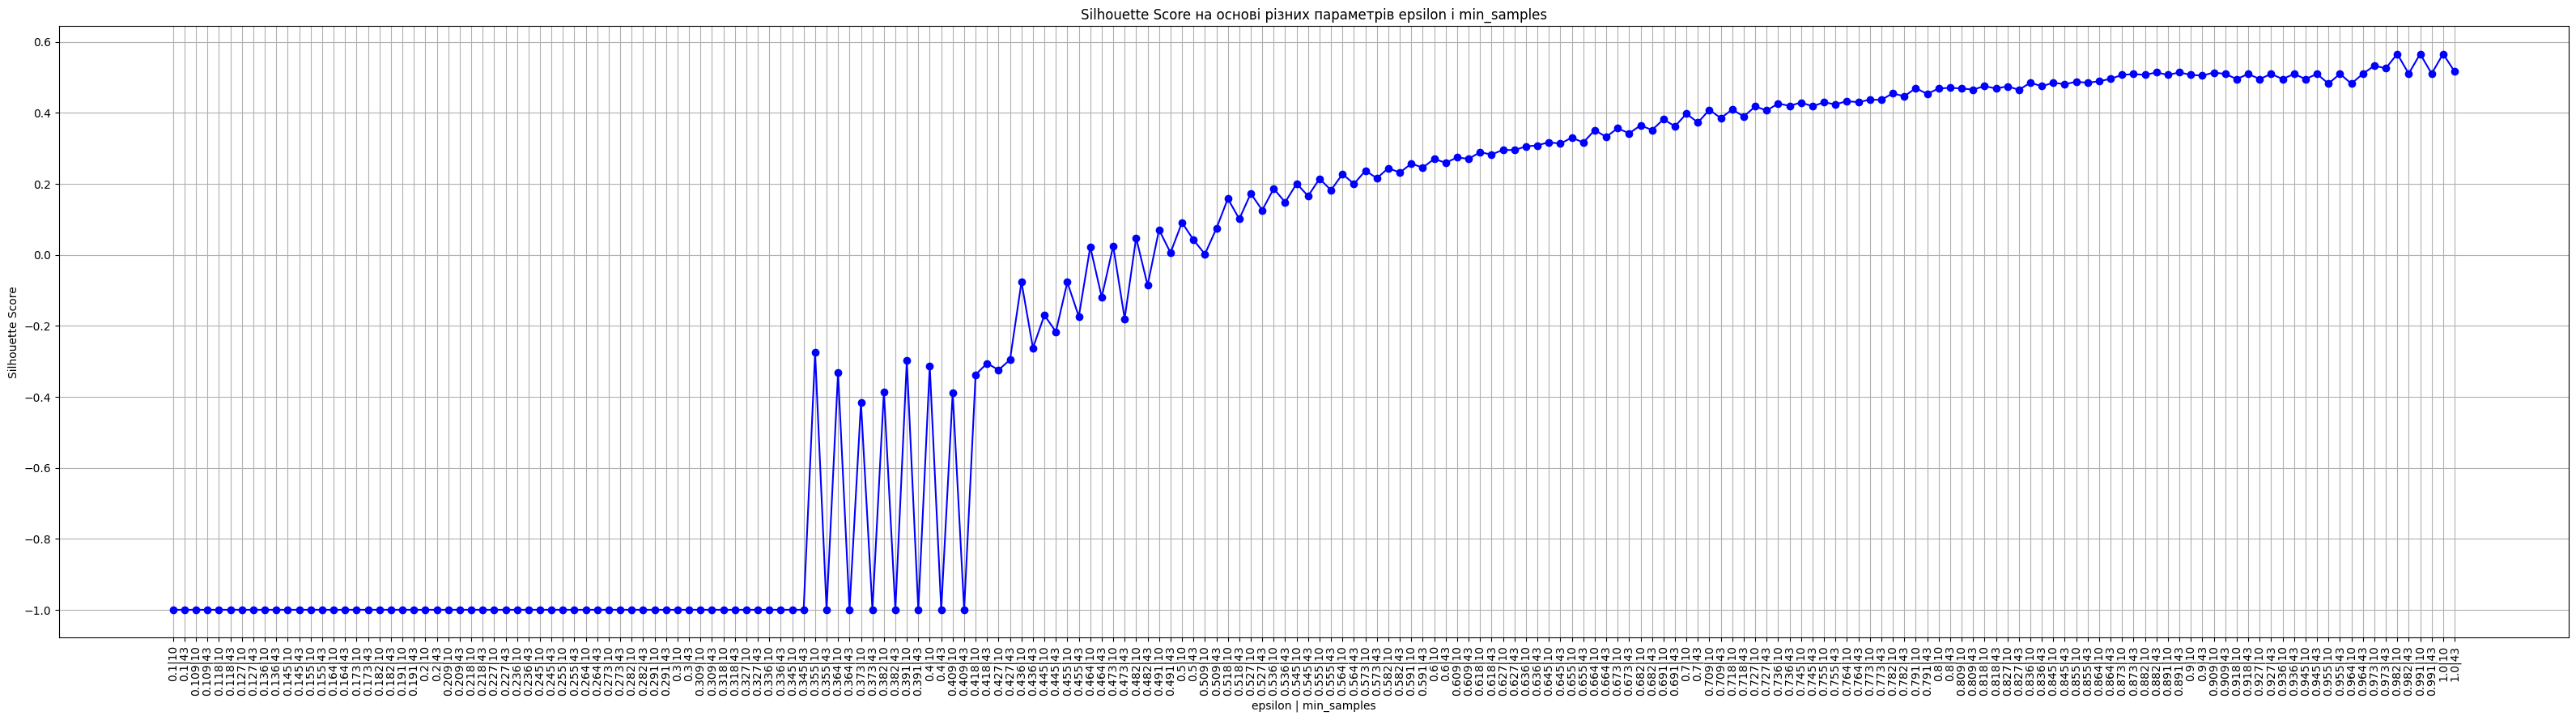

In [34]:
plot_silhouette_scores(scores, comb, figsize=(40, 10))

In [35]:
nc = NearestCentroid()
nc.fit(data_minmax.values, dbscan_model.labels_)
centers = nc.centroids_

In [36]:
def get_cmap(n, name='hsv') -> Callable:
    '''
    https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

class RainbowColorMap:
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet']
    def __call__(self, idx: int) -> str:
        return self.colors[idx]


def get_pallet(n, name='hsv'):
    if n > 7:
        return get_cmap(n, name)
    return RainbowColorMap()

In [37]:
def plot_radar_chart(cluster_centers: pd.DataFrame, text: str, prefix: str):
    labels = cluster_centers.cluster
    cluster_centers = cluster_centers.drop(columns=['cluster'])
    angles = np.linspace(0, 2*np.pi, cluster_centers.shape[1], endpoint=False)
    cmap: Callable = get_pallet(len(cluster_centers))
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, polar=True)
    # ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5))
    ax.set_thetagrids(angles * 180/np.pi, [col.replace(prefix, '') for col in cluster_centers.columns])
    cluster_labels = [f'Cluster {i}' for i in labels]
    ax.grid(True)
    plot_data = cluster_centers.values
    for i in range(len(plot_data)):
        ax.plot(angles, plot_data[i], 'o-', color=cmap(i),
                label=f'cluster {i}', linewidth=2)

    ax.legend(cluster_labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='large')
    fig.text(0.5, 0.965, text,
                horizontalalignment='center', color='black', weight='bold',
                size='large')
    plt.show()

In [38]:
df_centers = pd.DataFrame(nc.centroids_, columns=data_minmax.columns)
df_centers['cluster'] = nc.classes_

In [39]:
df_centers

MinMax_overall_rating  MinMax_potential  MinMax_value_euro  \
0               0.308489          0.319549           0.032170   
1               0.310518          0.309735           0.025185   

   MinMax_wage_euro  MinMax_international_reputation(1-5)  \
0          0.022290                              0.041632   
1          0.017206                              0.041293   

   MinMax_weak_foot(1-5)  MinMax_skill_moves(1-5)  MinMax_release_clause_euro  \
0               0.517370                 0.420356                    0.029286   
1               0.382843                 0.000000                    0.022887   

   MinMax_crossing  MinMax_finishing  ...  MinMax_composure  MinMax_marking  \
0         0.601015          0.541037  ...          0.626366        0.567118   
1         0.108631          0.116793  ...          0.445537        0.143124   

   MinMax_standing_tackle  MinMax_sliding_tackle  MinMax_GK_diving  \
0                0.566374               0.565545          0.108093   
1                0.096251               0.118989          0.778259   

   MinMax_GK_handling  MinMax_GK_kicking  MinMax_GK_positioning  \
0            0.106455           0.106301               0.108403   
1            0.731142           0.712161               0.761268   

   MinMax_GK_reflexes  cluster  
0            0.103486        0  
1            0.757879        1  

[2 rows x 43 columns]

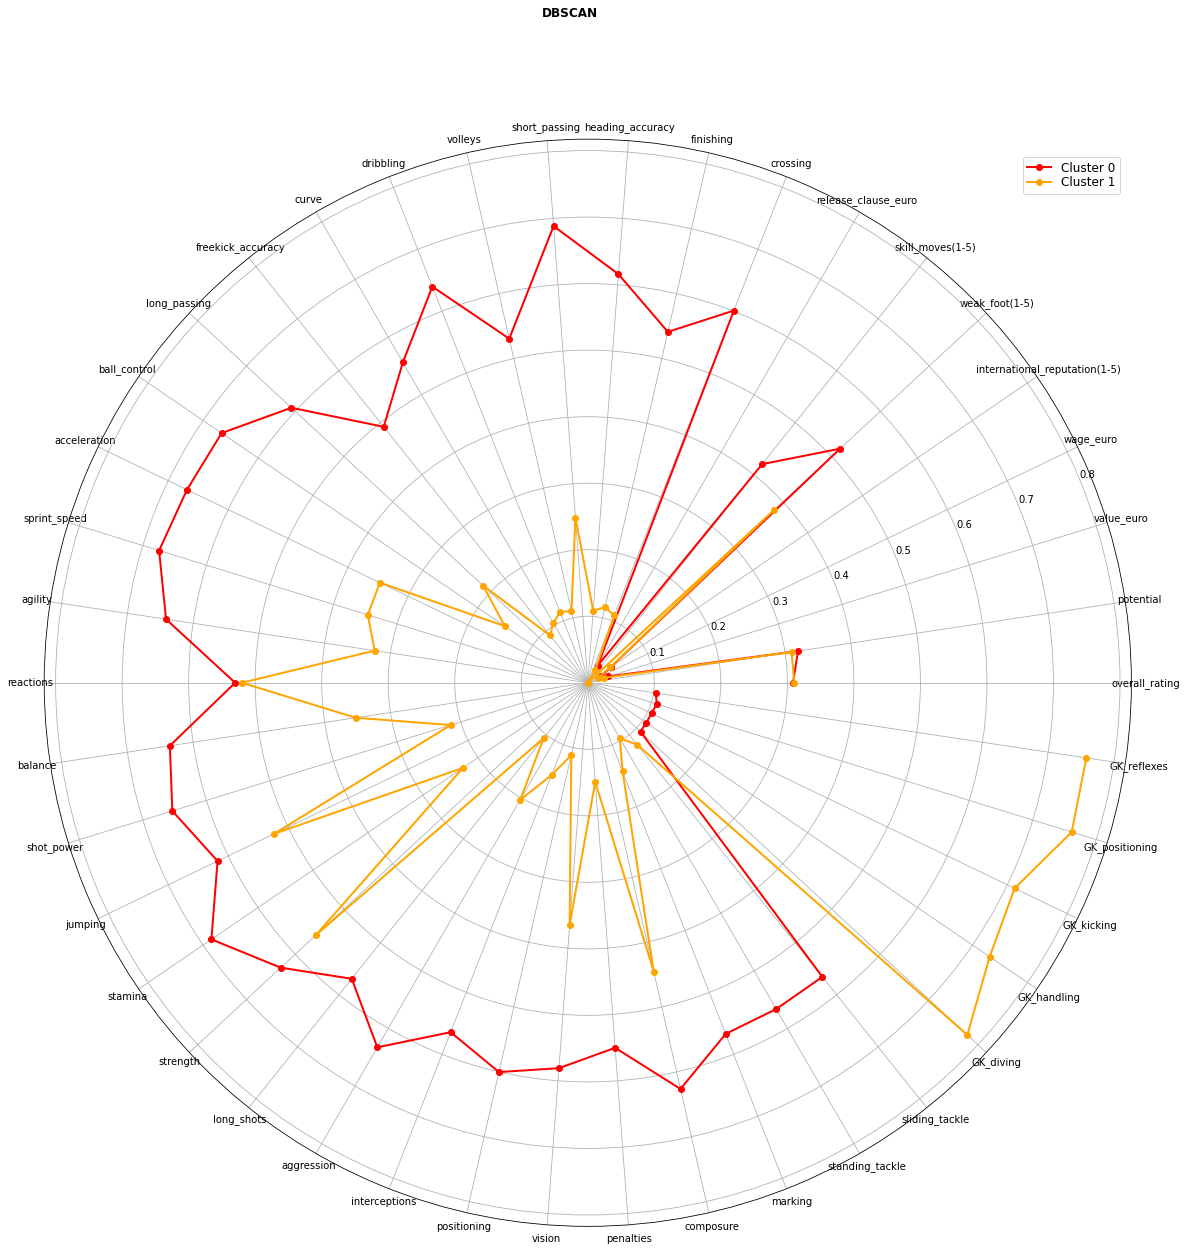

In [40]:
plot_radar_chart(df_centers, 'DBSCAN', 'MinMax_')

<AxesSubplot:>

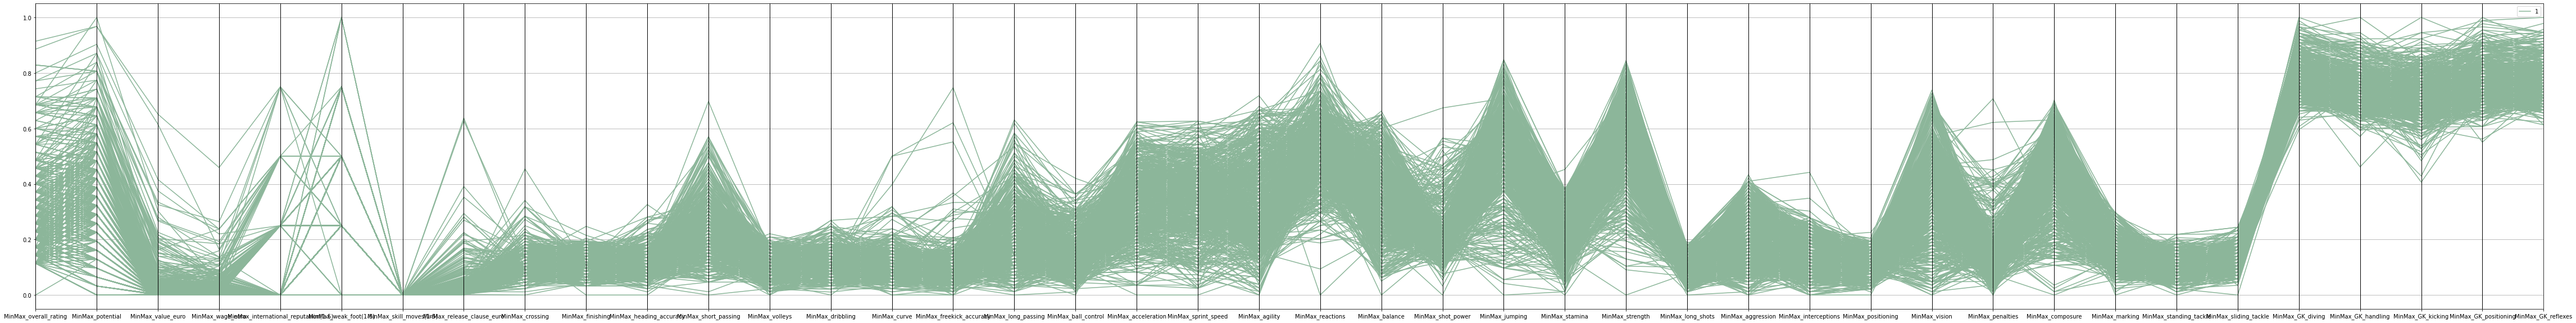

In [41]:
df_plot = data_minmax.copy()
df_plot['cluster'] = dbscan_model.labels_
fig = plt.figure(figsize=(80, 10))
ax = fig.add_subplot(111)
parallel_coordinates(df_plot[df_plot['cluster'] == 1], 'cluster', ax=ax)

## Birch

In [42]:
birchmodel = Birch(threshold=0.5, n_clusters=7)
birchmodel.fit(data_minmax.values)
# birchmodel.subcluster_centers_
# birchmodel.labels_

Birch(n_clusters=7)

In [43]:
pd.Series(birchmodel.labels_).value_counts()

0    2845
2    2167
4     902
3     781
5     573
1     383
6     312
dtype: int64

In [44]:
nc = NearestCentroid()
nc.fit(data_minmax.values, birchmodel.labels_)

NearestCentroid()

In [45]:
df_centers = pd.DataFrame(nc.centroids_, columns=data_minmax.columns)
df_centers['cluster'] = nc.classes_

In [46]:
df_centers

MinMax_overall_rating  MinMax_potential  MinMax_value_euro  \
0               0.313191          0.317478           0.027652   
1               0.593808          0.605491           0.179566   
2               0.280335          0.308692           0.020719   
3               0.310518          0.309735           0.025185   
4               0.250744          0.241971           0.013536   
5               0.222787          0.245623           0.011032   
6               0.435256          0.422870           0.064661   

   MinMax_wage_euro  MinMax_international_reputation(1-5)  \
0          0.021050                              0.034271   
1          0.119836                              0.282637   
2          0.012681                              0.017074   
3          0.017206                              0.041293   
4          0.010143                              0.017461   
5          0.008237                              0.007853   
6          0.041519                              0.115385   

   MinMax_weak_foot(1-5)  MinMax_skill_moves(1-5)  MinMax_release_clause_euro  \
0               0.486907                 0.363620                    0.025206   
1               0.622063                 0.657311                    0.166517   
2               0.570720                 0.520420                    0.018431   
3               0.382843                 0.000000                    0.022887   
4               0.432373                 0.250554                    0.012150   
5               0.515707                 0.380890                    0.009788   
6               0.544872                 0.515224                    0.058786   

   MinMax_crossing  MinMax_finishing  ...  MinMax_composure  MinMax_marking  \
0         0.628579          0.459663  ...          0.627107        0.698623   
1         0.793348          0.729498  ...          0.781549        0.624709   
2         0.665085          0.643827  ...          0.623107        0.439221   
3         0.108631          0.116793  ...          0.445537        0.143124   
4         0.373980          0.284088  ...          0.567535        0.697510   
5         0.466068          0.702434  ...          0.581318        0.274649   
6         0.572771          0.784222  ...          0.704556        0.345766   

   MinMax_standing_tackle  MinMax_sliding_tackle  MinMax_GK_diving  \
0                0.725984               0.735660          0.108853   
1                0.621110               0.601494          0.104321   
2                0.416610               0.410674          0.109052   
3                0.096251               0.118989          0.778259   
4                0.721182               0.719615          0.107103   
5                0.217087               0.210256          0.104575   
6                0.277888               0.252944          0.108470   

   MinMax_GK_handling  MinMax_GK_kicking  MinMax_GK_positioning  \
0            0.107182           0.106105               0.108813   
1            0.104668           0.107193               0.103030   
2            0.106051           0.106280               0.108600   
3            0.731142           0.712161               0.761268   
4            0.105906           0.105602               0.108772   
5            0.106841           0.107915               0.108006   
6            0.105699           0.106192               0.109551   

   MinMax_GK_reflexes  cluster  
0            0.103959        0  
1            0.098683        1  
2            0.104044        2  
3            0.757879        3  
4            0.102127        4  
5            0.104487        5  
6            0.103288        6  

[7 rows x 43 columns]

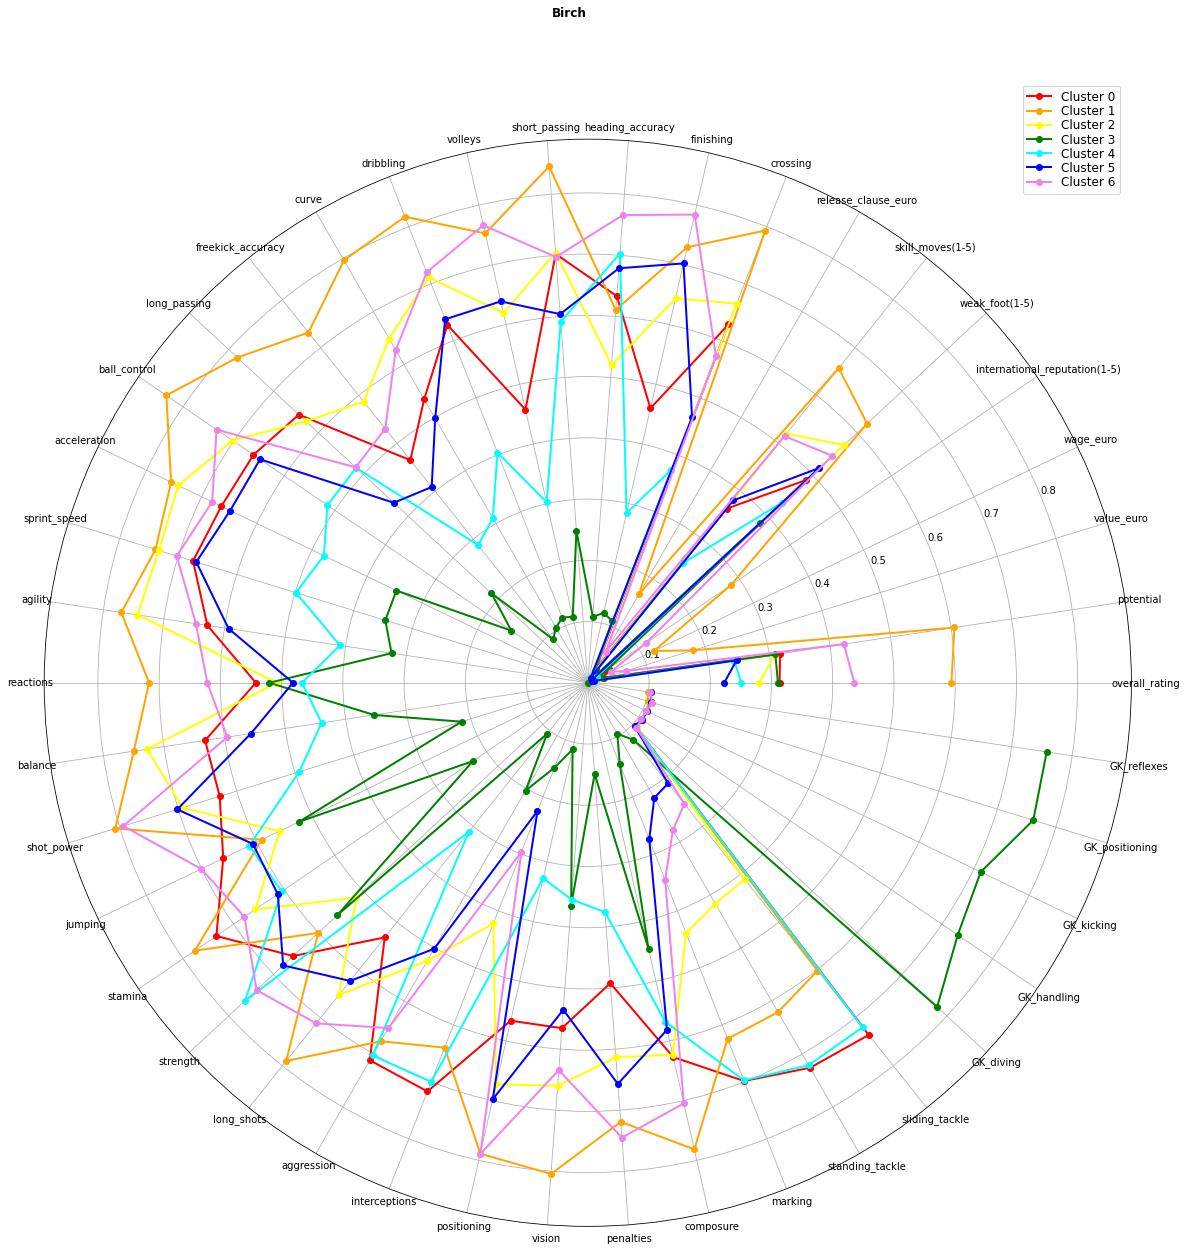

In [47]:
plot_radar_chart(df_centers, 'Birch', 'MinMax_')

In [48]:
silhouette_score(data_minmax.values, birchmodel.labels_, metric='euclidean')

0.16904658098252398

<AxesSubplot:>

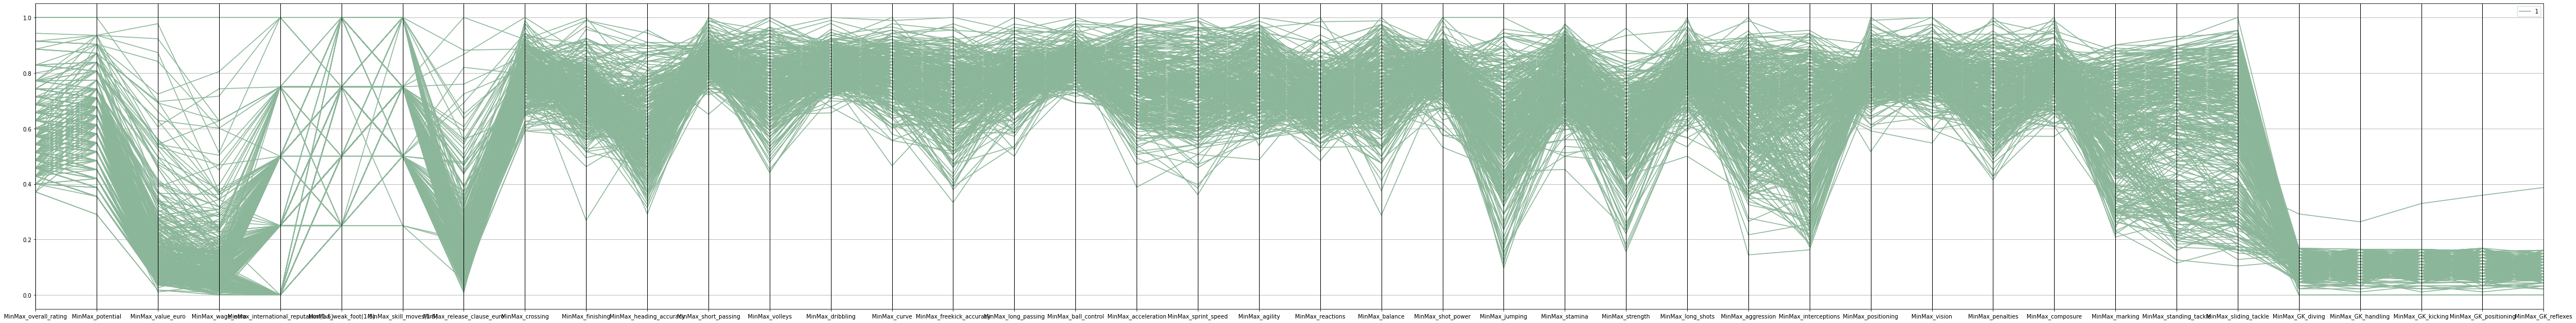

In [49]:
df_plot = data_minmax.copy()
df_plot['cluster'] = birchmodel.labels_
fig = plt.figure(figsize=(80, 10))
ax = fig.add_subplot(111)
parallel_coordinates(df_plot[df_plot['cluster'] == 1], 'cluster', ax=ax)